In [1]:
import os, sys
# add to path
from pathlib import Path

sys.path.append("../..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from filterflow.base import State
from filterflow.resampling import (RegularisedTransform, 
                                   PartiallyCorrectedRegularizedTransform, 
                                   CorrectedRegularizedTransform, 
                                   OptimizedPointCloud, 
                                   SGD, 
                                   SinkhornLoss, 
                                   MultinomialResampler, 
                                   SystematicResampler, 
                                   StratifiedResampler, 
                                   NoResampling)

In [3]:
random_state = np.random.RandomState(42)
N = 25
x = random_state.normal(0., 1., [N, 2]).astype(np.float32)
w = random_state.uniform(0., 1., [N]).astype(np.float32) ** 2
w /= w.sum()

log_w = np.log(w)

In [20]:
state = State(tf.convert_to_tensor(x[None, :, :]), tf.convert_to_tensor(log_w[None, :]))
flag = tf.constant([True])

In [5]:
epsilons = [0.01, 0.05, 0.1, 0.25, 0.33, 0.5, 0.75, 1.]

In [6]:
regularized_states = []
for epsilon in epsilons:
    regularized_transform = RegularisedTransform(tf.constant(epsilon))
    resampled_state = regularized_transform.apply(state, flag)
    regularized_states.append(resampled_state.particles[0].numpy())

In [21]:
optimized_states_non_sym = []

for epsilon in epsilons:
    loss = SinkhornLoss(tf.constant(epsilon), max_iter=100)
    sgd = SGD(loss, decay=0.95, lr=1., n_iter=100)
    intermediate_resampler = NoResampling()
    cloud_optimizer = OptimizedPointCloud(sgd, intermediate_resampler)
    resampled_state = cloud_optimizer.apply(state, flag)
    optimized_states_non_sym.append(resampled_state.particles[0].numpy())

In [8]:
optimized_states_sym = []

for epsilon in epsilons:
    loss = SinkhornLoss(tf.constant(epsilon), max_iter=100, symmetric=True)
    sgd = SGD(loss, decay=0.99, lr=10., n_iter=100)
    intermediate_resampler = NoResampling()
    cloud_optimizer = OptimizedPointCloud(sgd, intermediate_resampler)
    resampled_state = cloud_optimizer.apply(state, flag)
    optimized_states_sym.append(resampled_state.particles[0].numpy())

In [9]:
variance_corrected_states = []
for epsilon in epsilons:
    regularized_transform = RegularisedTransform(tf.constant(epsilon))
    variance_corrected_transform = PartiallyCorrectedRegularizedTransform(regularized_transform)
    resampled_state = variance_corrected_transform.apply(state, flag)
    variance_corrected_states.append(resampled_state.particles[0].numpy())

In [10]:
covariance_corrected_states = []
for epsilon in epsilons:
    covariance_corrected_transform = CorrectedRegularizedTransform(tf.constant(epsilon))
    resampled_state = covariance_corrected_transform.apply(state, flag)
    covariance_corrected_states.append(resampled_state.particles[0].numpy())

In [11]:
multinomial_resampler = MultinomialResampler()
multinomial_state = multinomial_resampler.apply(state, flag).particles[0].numpy()

systematic_resampler = SystematicResampler()
systematic_state = systematic_resampler.apply(state, flag).particles[0].numpy()

stratified_resampler = StratifiedResampler()
stratified_state = stratified_resampler.apply(state, flag).particles[0].numpy()

In [12]:
def plot_scatter(state, directory, epsilon):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-3., 3.)
    ax.set_ylim(-3., 3.)
    g = sns.jointplot(x=state[:, 0], y=state[:, 1], kind="kde", color='xkcd:light grey', ax=ax)
    g.plot_joint(ax.scatter, c="w", s=30, linewidth=1, marker="o")
    ax.set_alpha(0)
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")

    ax.set_facecolor('xkcd:light grey')
    dir_path = os.path.join("./charts/illustrations", directory)
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    
    fig.savefig(os.path.join(dir_path, f"epsilon{str(epsilon)}.png"))
    plt.close()

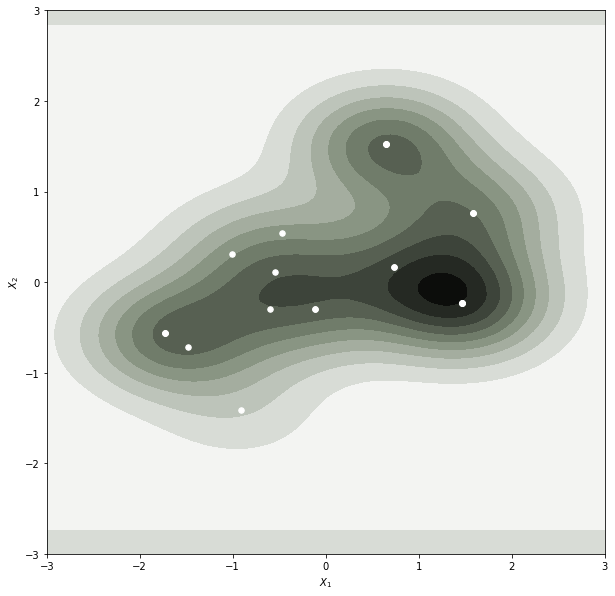

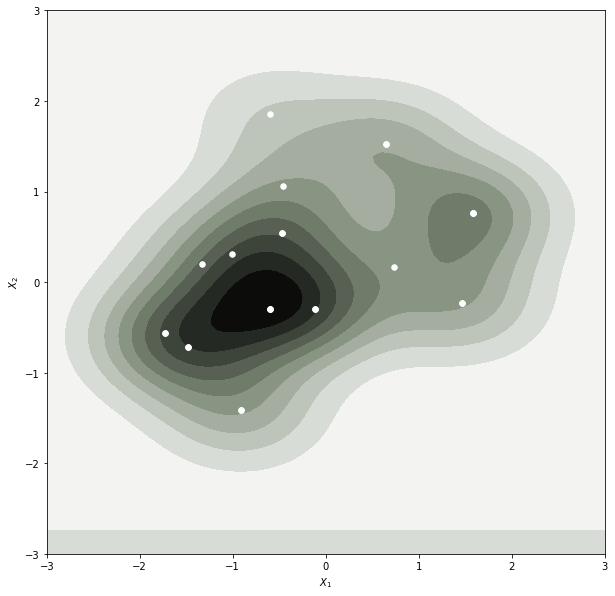

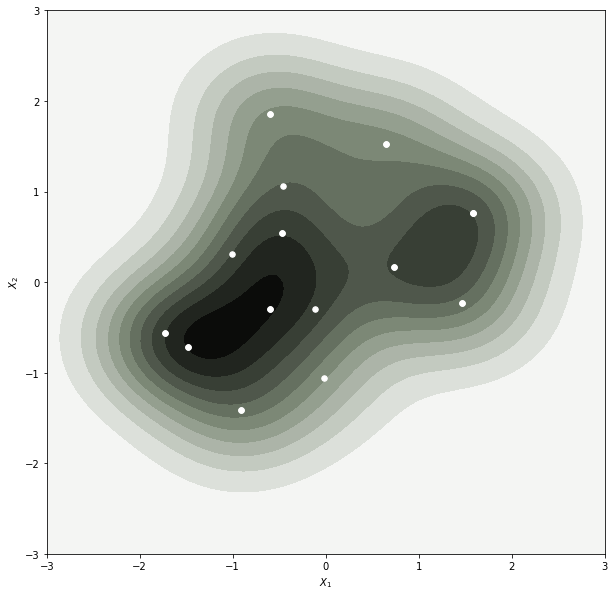

In [13]:
plot_scatter(multinomial_state, "standard", "multinomial")
plot_scatter(systematic_state, "standard", "systematic")
plot_scatter(stratified_state, "standard", "stratified")

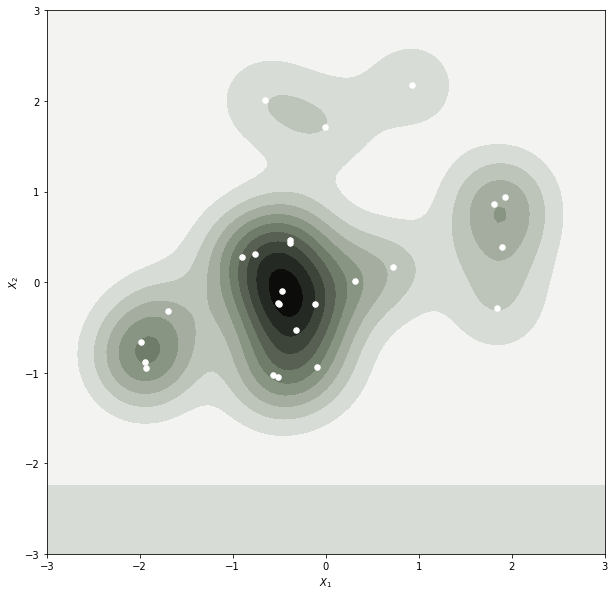

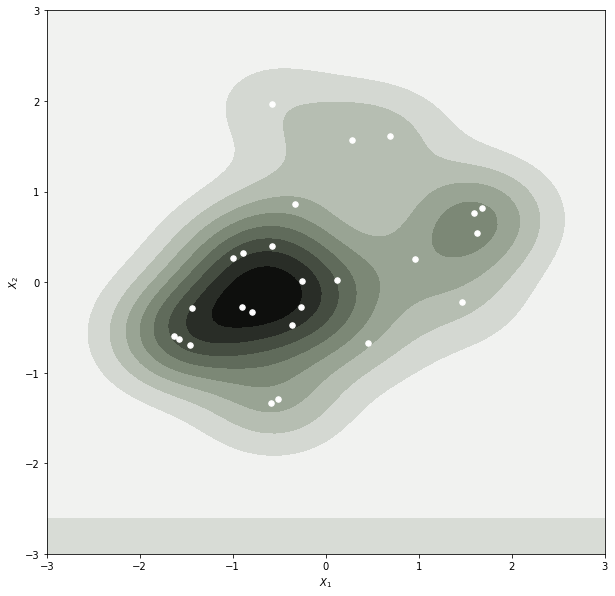

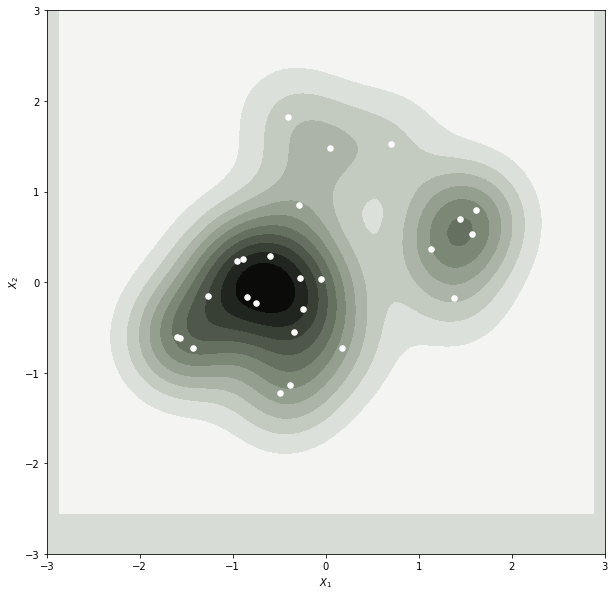

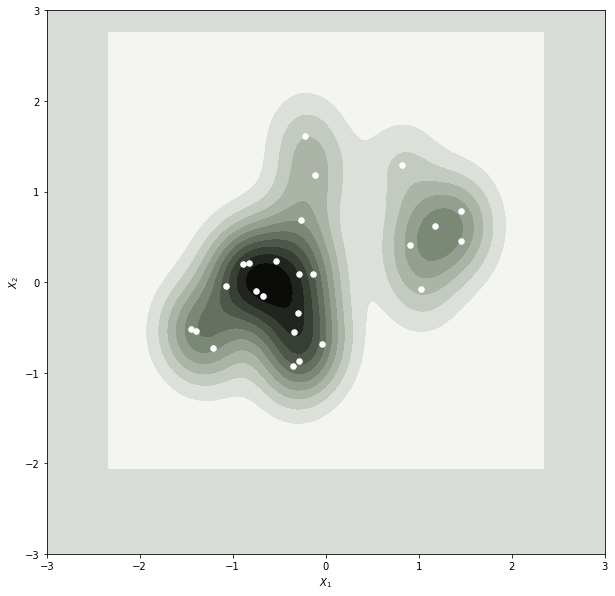

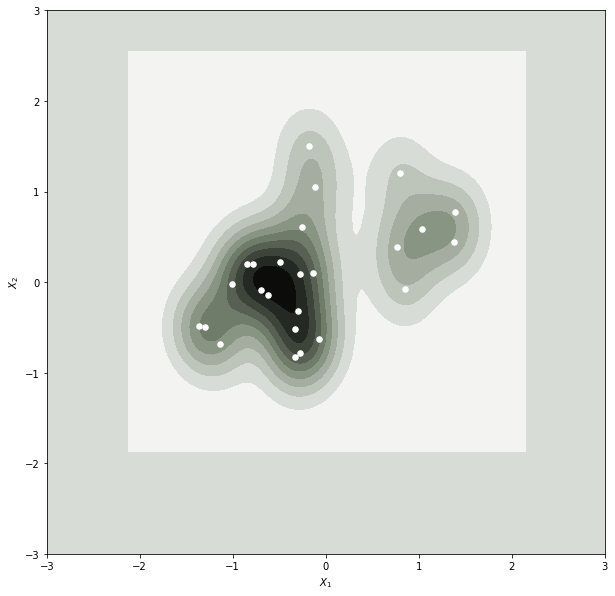

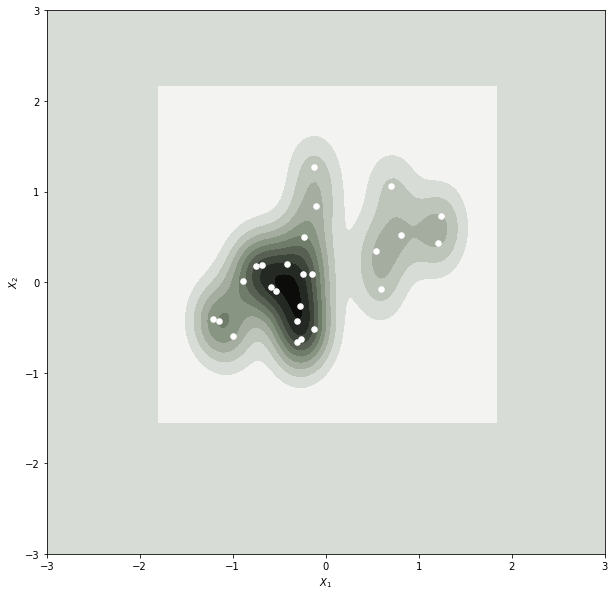

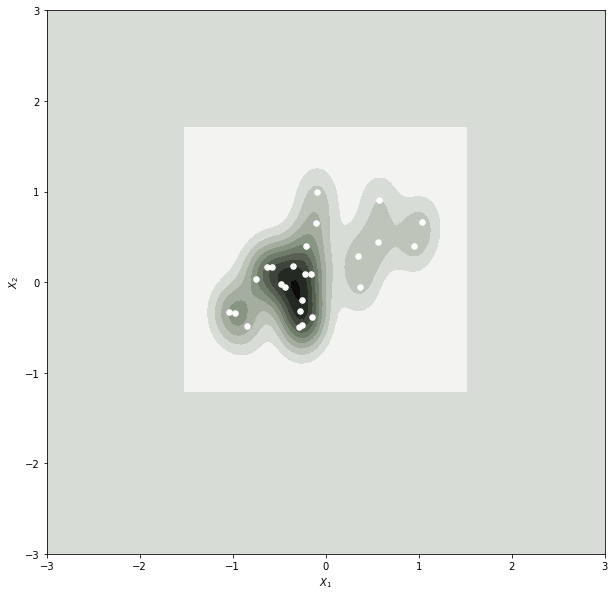

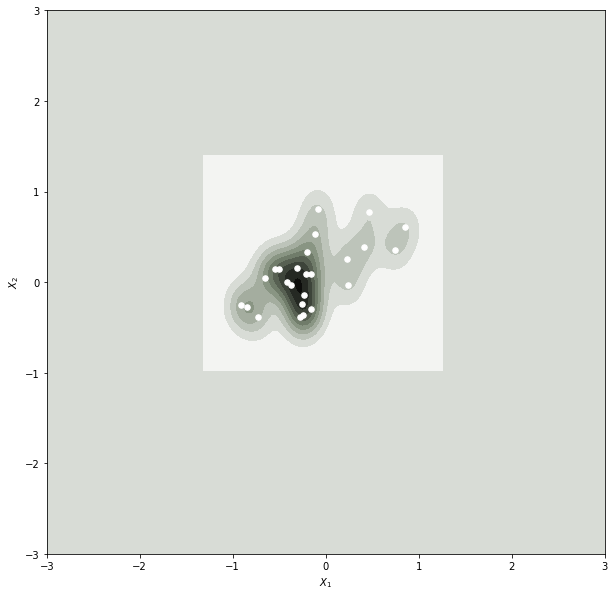

In [14]:
for epsilon, state in zip(epsilons, regularized_states):
    plot_scatter(state, "regularized", epsilon)

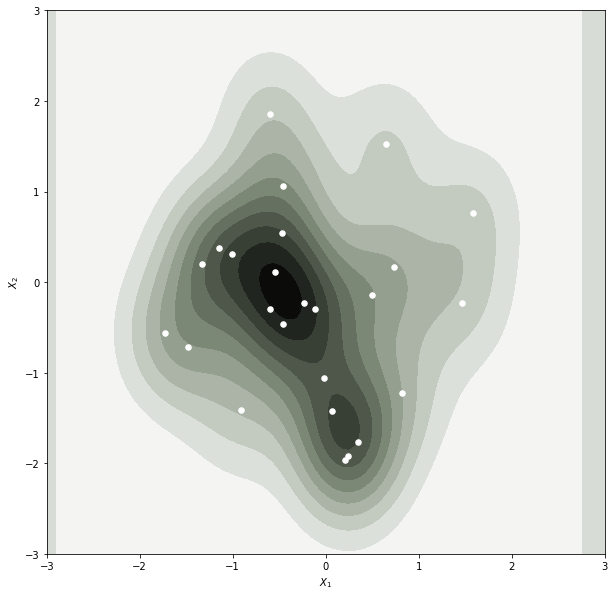

In [15]:
plot_scatter(x, "standard", "degenerate")

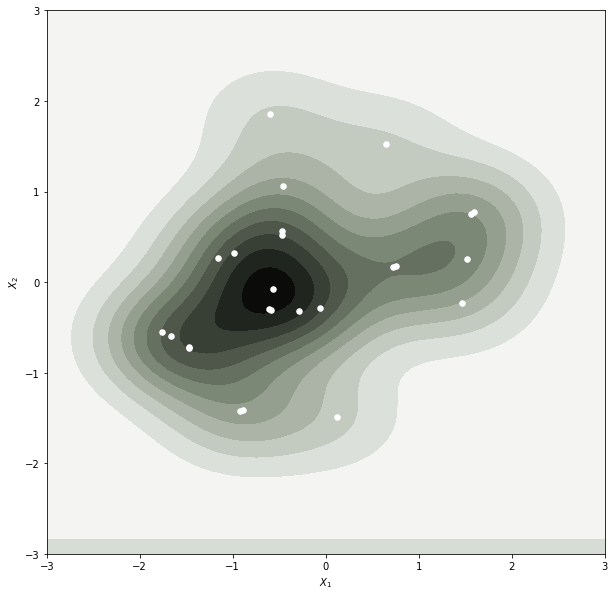

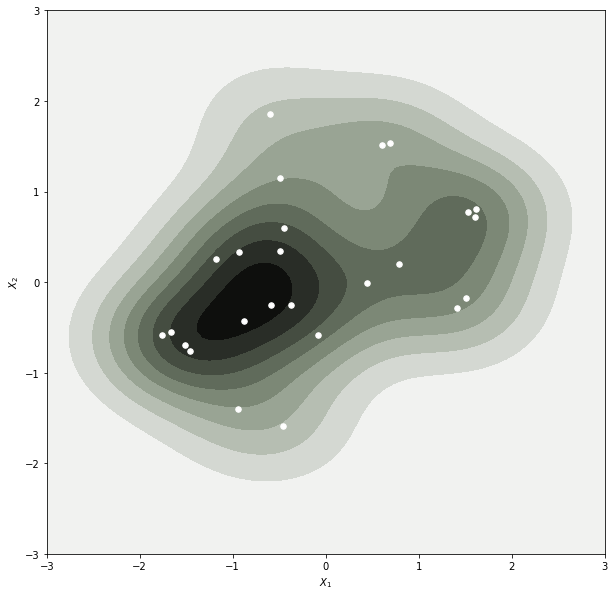

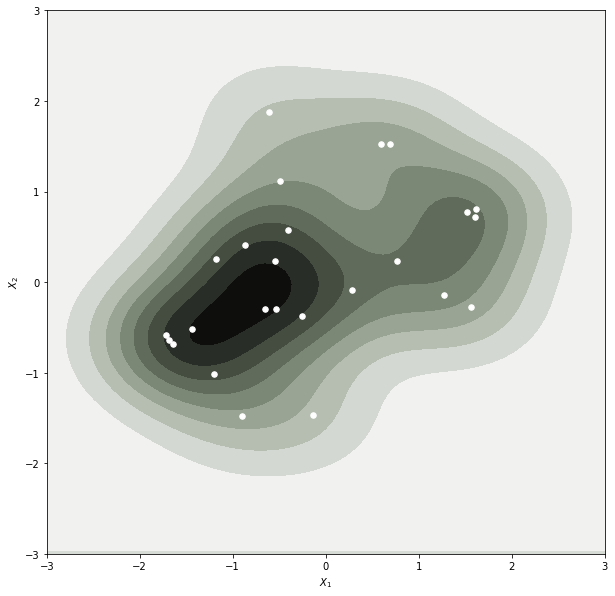

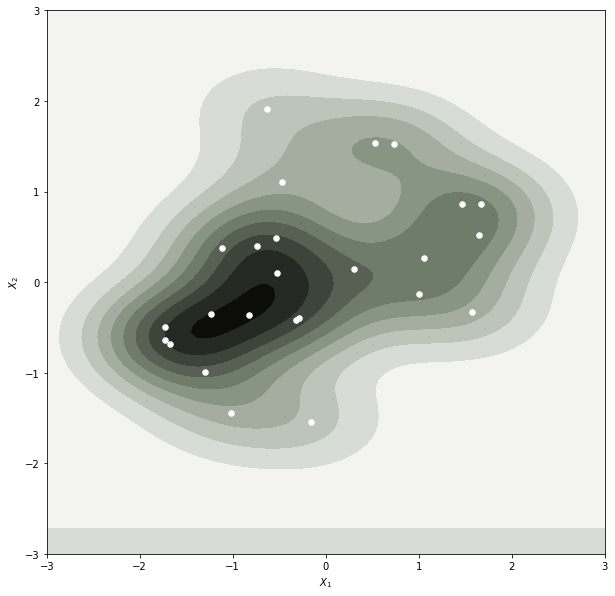

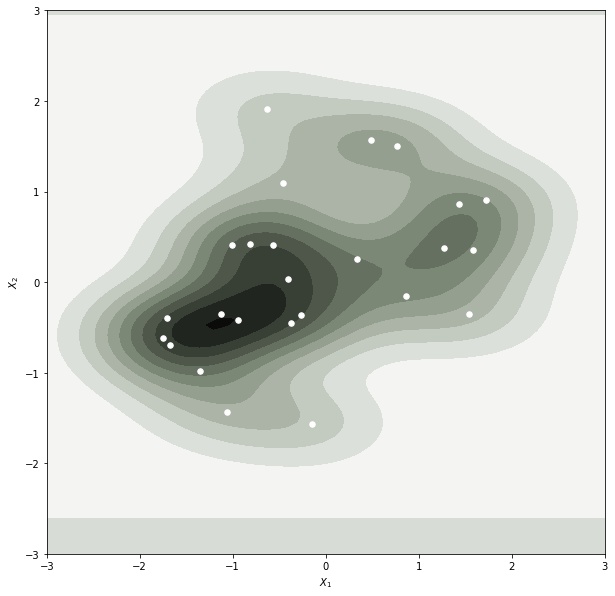

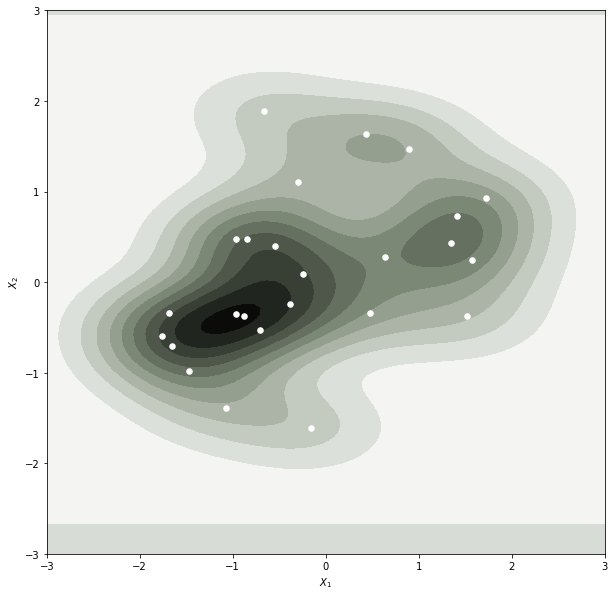

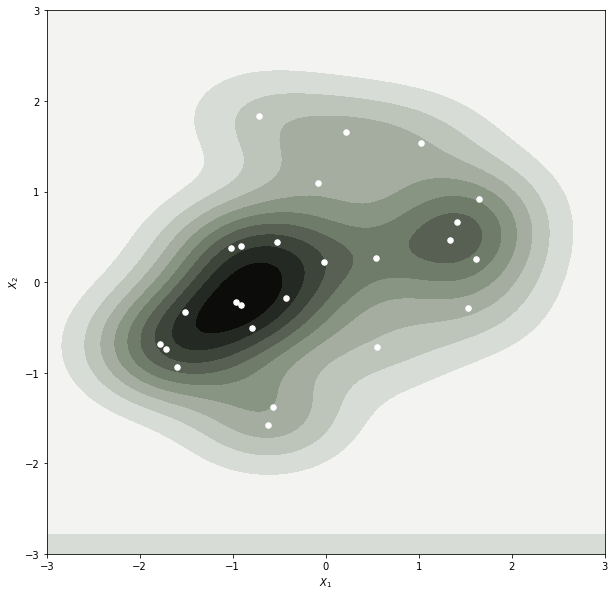

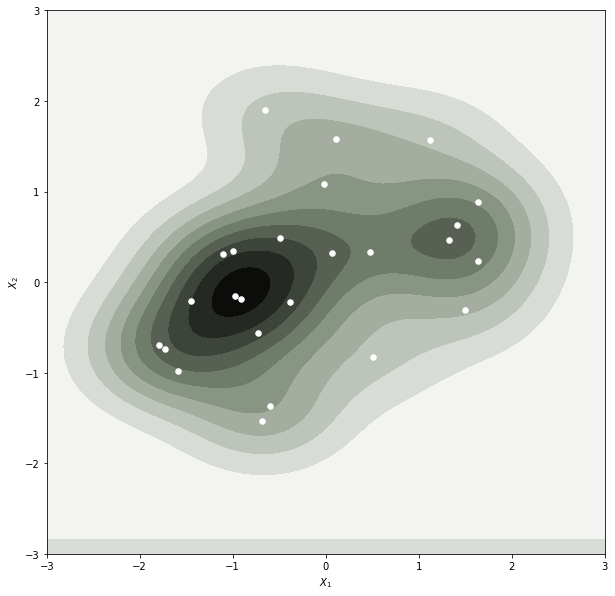

In [16]:
for epsilon, state in zip(epsilons, optimized_states_sym):
    plot_scatter(state, "optimized_sym", epsilon)

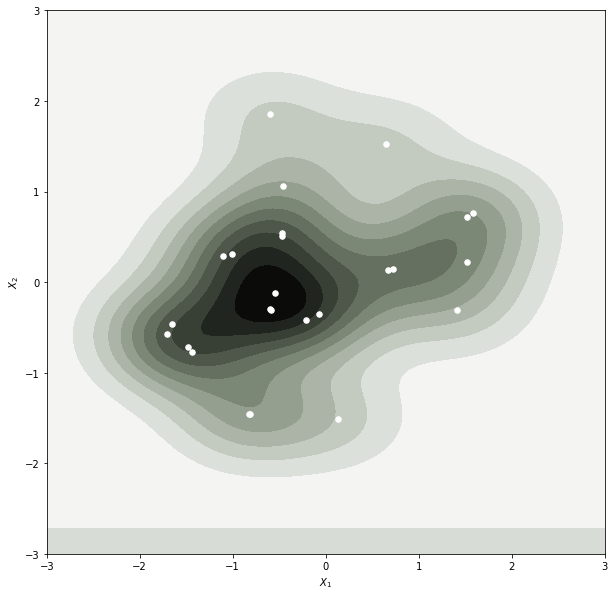

In [17]:
for epsilon, state in zip(epsilons, optimized_states_non_sym):
    plot_scatter(state, "optimized_biased", epsilon)

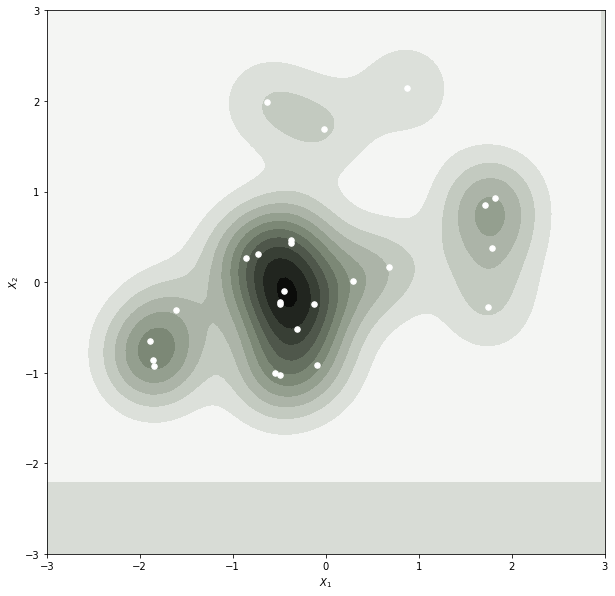

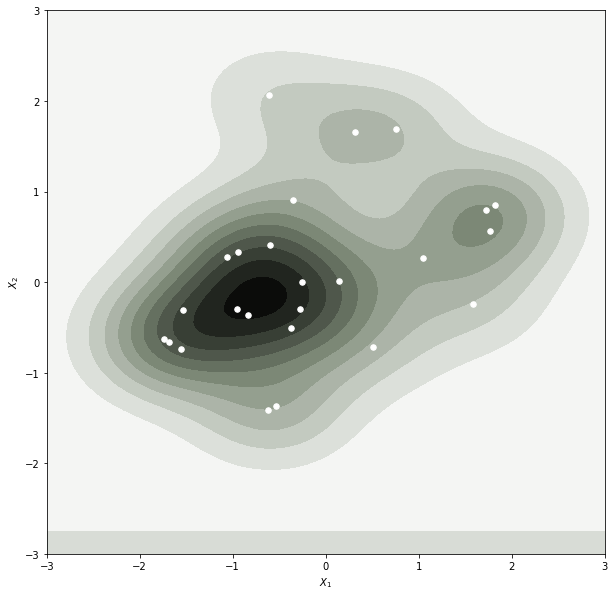

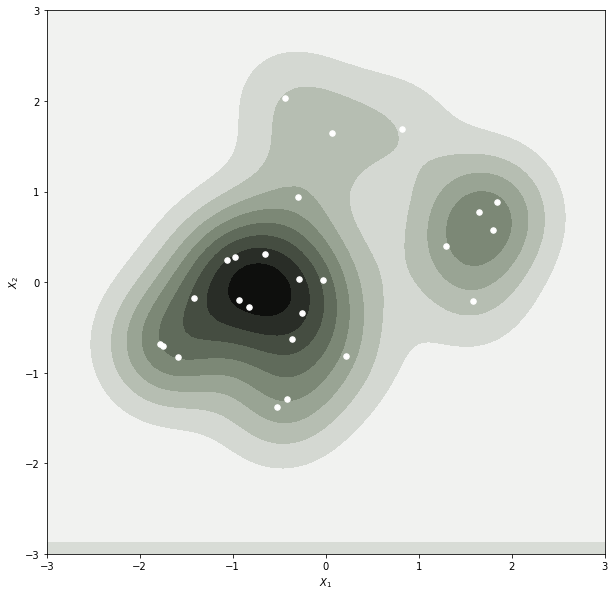

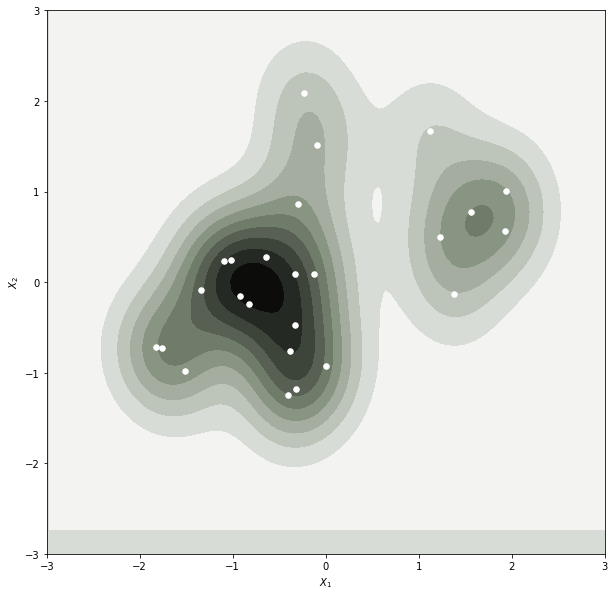

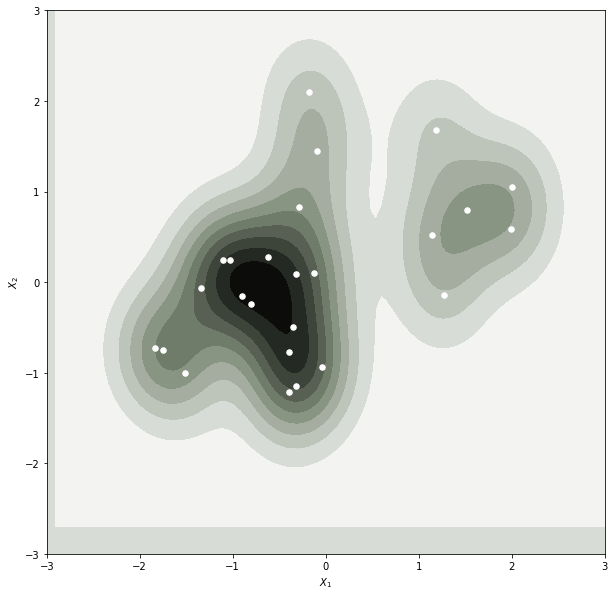

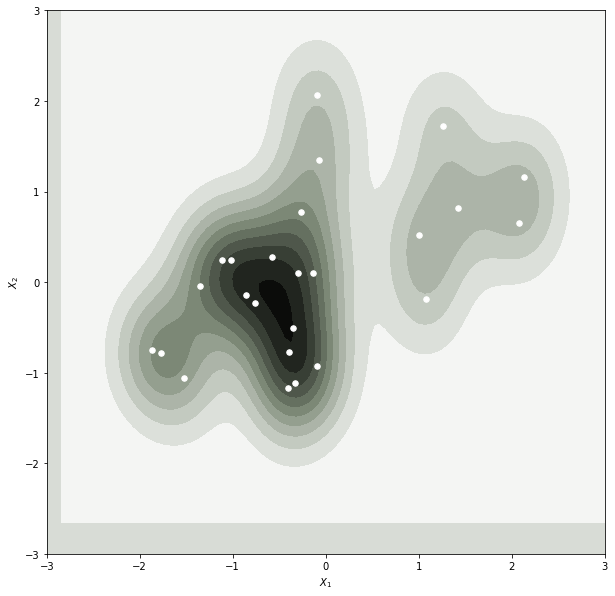

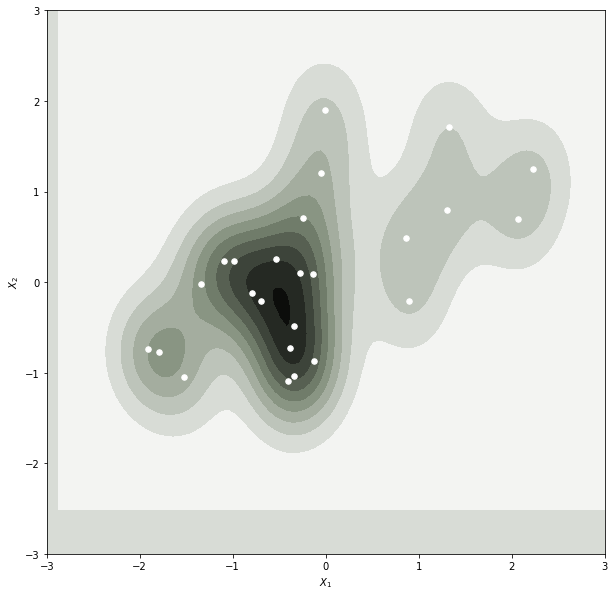

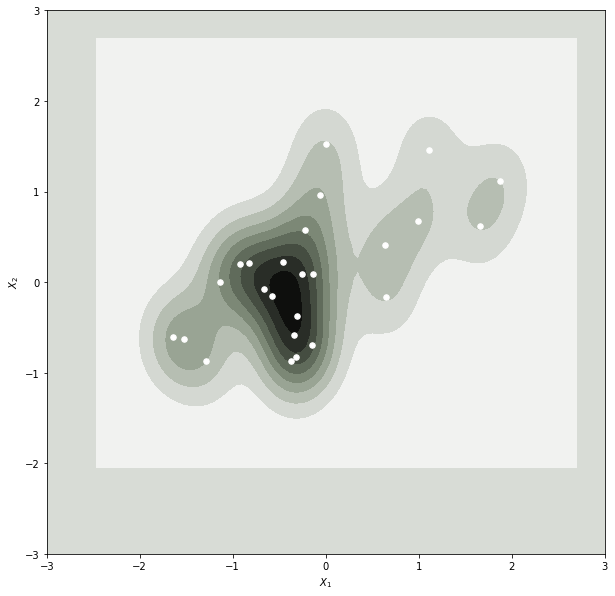

In [18]:
for epsilon, state in zip(epsilons, variance_corrected_states):
    plot_scatter(state, "variance", epsilon)

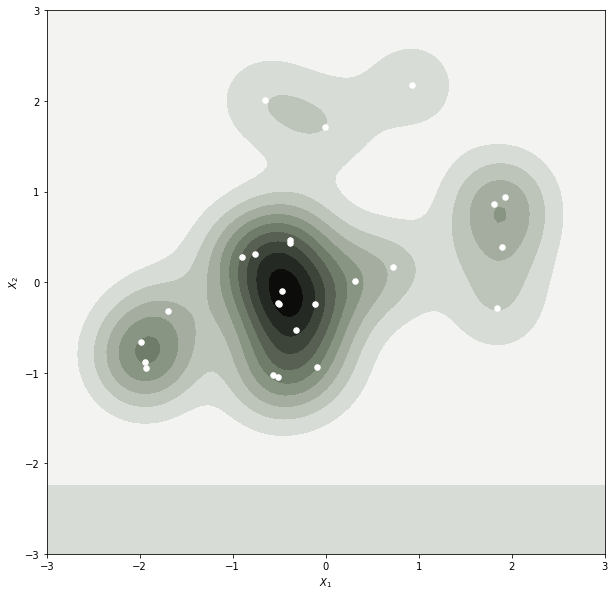

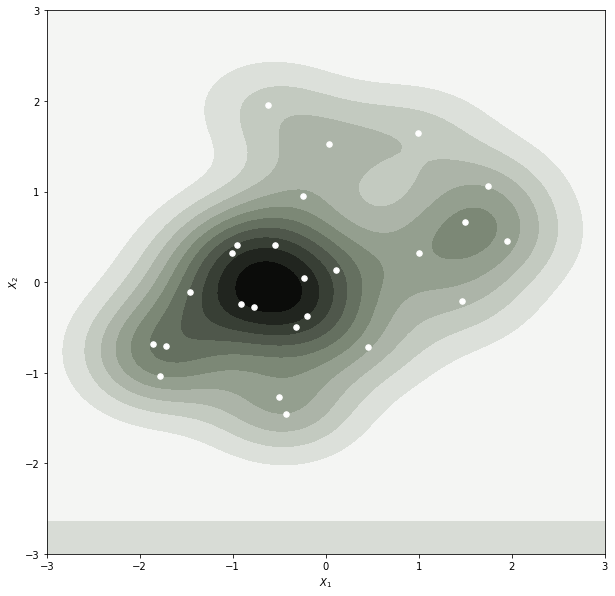

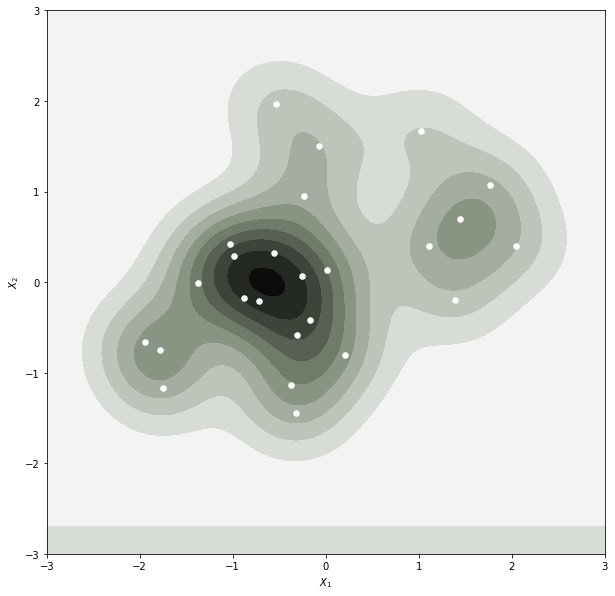

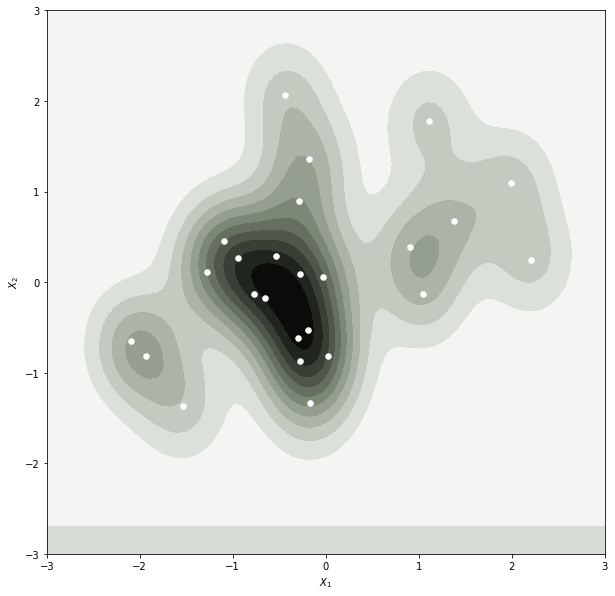

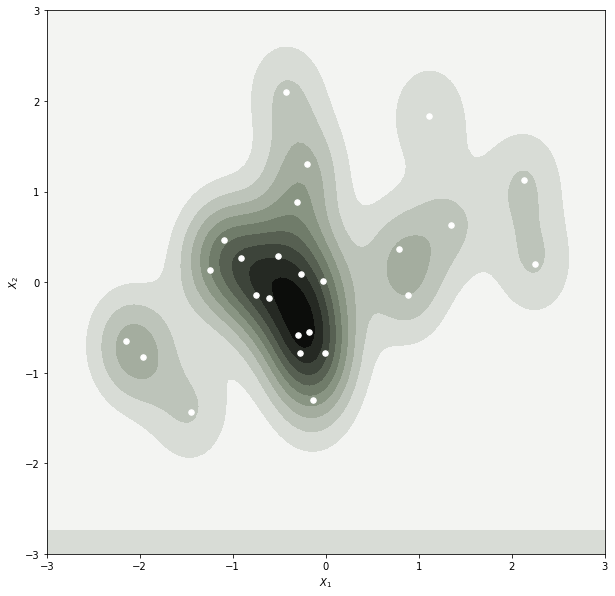

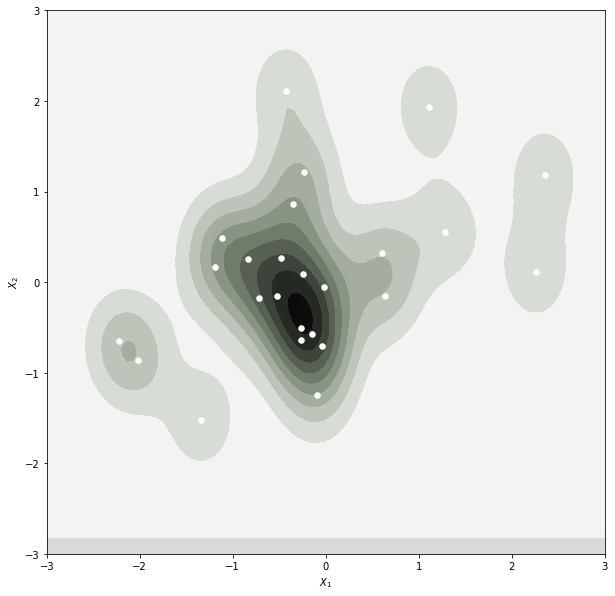

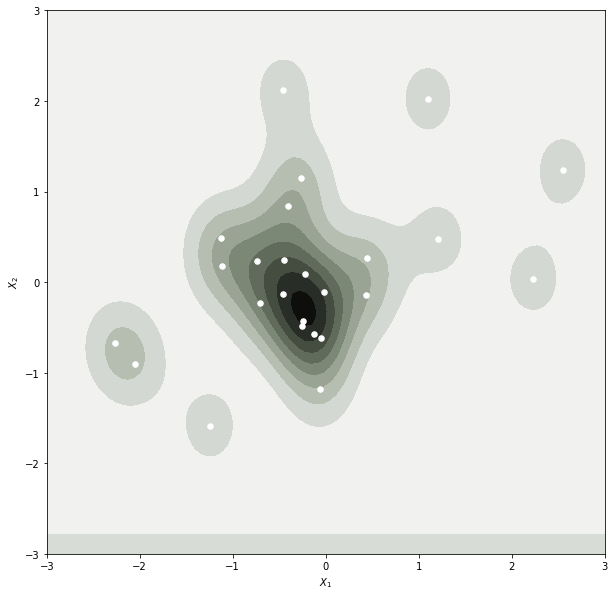

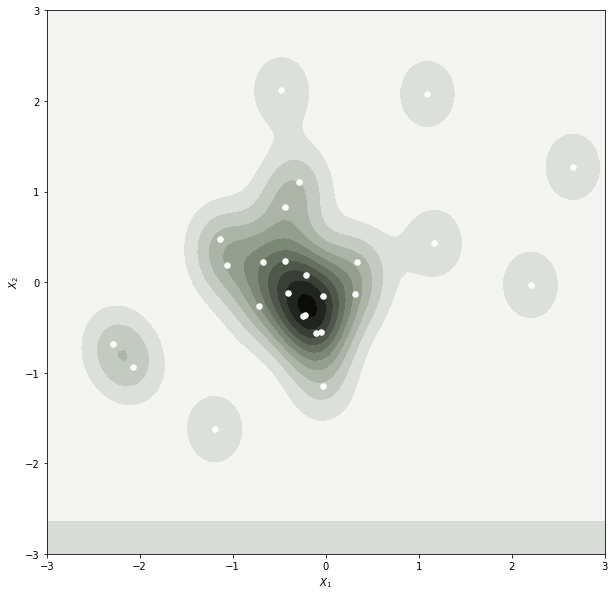

In [19]:
for epsilon, state in zip(epsilons, covariance_corrected_states):
    plot_scatter(state, "covariance", epsilon)